In [1]:
# ==============================================================
# 🧩 SVM Experiments – LinearSVC + SVC (RBF)
# ==============================================================

# Core libraries
import pandas as pd
import numpy as np

# Scikit-learn
from sklearn.svm import SVC, LinearSVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Local project imports
from preprocessing import prepare_data

# Experiment config
ratios = [None, 0.05, 0.1, 0.2, 0.3, 0.5, 1.0]
random_state = 42
results = []


In [2]:
# ==============================================================
# Load Dataset
# ==============================================================

train_df = pd.read_csv("fraudTrain.csv")
test_df  = pd.read_csv("fraudTest.csv")

print(f"Train shape: {train_df.shape} | Test shape: {test_df.shape}")
print("Fraud ratio (train):", train_df["is_fraud"].mean())
print("Fraud ratio (test):", test_df["is_fraud"].mean())


Train shape: (1296675, 23) | Test shape: (555719, 23)
Fraud ratio (train): 0.005788651743883394
Fraud ratio (test): 0.0038598644278853163


In [3]:
# ==============================================================
# Prepare Base Test Set (shared across all experiments)
# ==============================================================

out_train_init = prepare_data(
    train_df,
    mode="linear",  # keep standardized scaling for SVM
    training=True,
    ratio=0.1,
    fit=True
)
encoders = out_train_init["encoders"]
scalers  = out_train_init["scalers"]

out_test = prepare_data(
    test_df,
    mode="linear",
    training=False,
    fit=False,
    encoders=encoders,
    scalers=scalers
)
df_test = out_test["df"]
X_test  = df_test.drop("is_fraud", axis=1)
y_test  = df_test["is_fraud"]

print("Test set shape:", X_test.shape, "| Fraud ratio:", y_test.mean())


Test set shape: (555719, 25) | Fraud ratio: 0.0038598644278853163


In [4]:
# ==============================================================
# Train + Evaluate SVMs Across Ratios
# ==============================================================

import sys
import time
from datetime import datetime

partial_save_path = "results/svm_partial.csv"

# Avoid convergence warnings spam
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)

for ratio_idx, ratio in enumerate(ratios, start=1):
    print(f"\n{'='*70}")
    print(f"[{datetime.now().strftime('%H:%M:%S')}] Starting ratio {ratio_idx}/{len(ratios)} → ratio={ratio}")
    sys.stdout.flush()
    start_ratio_time = time.time()

    out_train = prepare_data(
        train_df,
        mode="linear",
        training=True,
        ratio=ratio,
        fit=True
    )

    for resample_type in ["df_up", "df_down"]:
        if resample_type not in out_train or out_train[resample_type] is None:
            continue

        df_train = out_train[resample_type]
        X_train = df_train.drop("is_fraud", axis=1)
        y_train = df_train["is_fraud"]

        X_train = X_train.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)
        X_test  = X_test.replace([np.inf, -np.inf], np.nan).fillna(0).clip(-1e6, 1e6)

        print(f"  [{datetime.now().strftime('%H:%M:%S')}] → Training on {resample_type} (samples={len(X_train):,})")
        sys.stdout.flush()

        # ----------------------------------------------------------
        # Model 1: LinearSVC (fast baseline)
        # ----------------------------------------------------------
        model_name = "LinearSVC"
        lin_model = LinearSVC(random_state=random_state, max_iter=5000)
        lin_model.fit(X_train, y_train)

        y_pred_lin = lin_model.predict(X_test)
        # LinearSVC doesn’t output probabilities, so use decision function
        y_score_lin = lin_model.decision_function(X_test)
        auc_lin = roc_auc_score(y_test, y_score_lin)

        results.append({
            "model": model_name,
            "ratio": ratio,
            "resample_type": resample_type.replace("df_", ""),
            "accuracy": accuracy_score(y_test, y_pred_lin),
            "precision": precision_score(y_test, y_pred_lin),
            "recall": recall_score(y_test, y_pred_lin),
            "f1": f1_score(y_test, y_pred_lin),
            "roc_auc": auc_lin
        })
        print(f"    ✅ {model_name} {resample_type} ratio={ratio} | F1={results[-1]['f1']:.4f}, Recall={results[-1]['recall']:.4f}, AUC={auc_lin:.4f}")

    # Save intermediate results
    pd.DataFrame(results).to_csv(partial_save_path, index=False)
    print(f"  💾 Saved intermediate results → {partial_save_path}")
    print(f"  ✅ Completed ratio={ratio} in {(time.time() - start_ratio_time)/60:.1f} min")

print("\nAll ratios completed.")
print(f"Total experiments logged: {len(results)}")
print(f"Results saved at: {partial_save_path}")



[22:11:08] Starting ratio 1/7 → ratio=None
  [22:11:12] → Training on df_up (samples=1,296,675)


/home/harsh/School/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


    ✅ LinearSVC df_up ratio=None | F1=0.0000, Recall=0.0000, AUC=0.8308
  [22:11:23] → Training on df_down (samples=1,296,675)
    ✅ LinearSVC df_down ratio=None | F1=0.0000, Recall=0.0000, AUC=0.8308
  💾 Saved intermediate results → results/svm_partial.csv
  ✅ Completed ratio=None in 0.4 min

[22:11:34] Starting ratio 2/7 → ratio=0.05


/home/harsh/School/venv/lib/python3.13/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


  [22:11:40] → Training on df_up (samples=1,353,627)
    ✅ LinearSVC df_up ratio=0.05 | F1=0.3725, Recall=0.2755, AUC=0.8286
  [22:11:52] → Training on df_down (samples=157,626)
    ✅ LinearSVC df_down ratio=0.05 | F1=0.3734, Recall=0.2783, AUC=0.8286
  💾 Saved intermediate results → results/svm_partial.csv
  ✅ Completed ratio=0.05 in 0.3 min

[22:11:54] Starting ratio 3/7 → ratio=0.1
  [22:12:00] → Training on df_up (samples=1,418,086)
    ✅ LinearSVC df_up ratio=0.1 | F1=0.3291, Recall=0.3790, AUC=0.8284
  [22:12:13] → Training on df_down (samples=82,566)
    ✅ LinearSVC df_down ratio=0.1 | F1=0.3261, Recall=0.3795, AUC=0.8282
  💾 Saved intermediate results → results/svm_partial.csv
  ✅ Completed ratio=0.1 in 0.3 min

[22:12:14] Starting ratio 4/7 → ratio=0.2
  [22:12:20] → Training on df_up (samples=1,547,003)
    ✅ LinearSVC df_up ratio=0.2 | F1=0.1988, Recall=0.4527, AUC=0.8293
  [22:12:36] → Training on df_down (samples=45,036)
    ✅ LinearSVC df_down ratio=0.2 | F1=0.2060, Recal

,model,ratio,resample_type,accuracy,precision,recall,f1,roc_auc
0,LinearSVC,0.05,down,0.996394,0.566952,0.278322,0.373358,0.828638
1,LinearSVC,0.05,up,0.996417,0.574903,0.275524,0.372518,0.828637
2,LinearSVC,0.10,up,0.994037,0.290877,0.379021,0.329150,0.828377
3,LinearSVC,0.10,down,0.993947,0.285915,0.379487,0.326122,0.828216
4,LinearSVC,0.20,down,0.986376,0.132882,0.457809,0.205978,0.829092
5,LinearSVC,0.20,up,0.985914,0.127344,0.452681,0.198772,0.829260
6,LinearSVC,0.30,up,0.979473,0.096743,0.517949,0.163035,0.833635
7,LinearSVC,0.30,down,0.979108,0.095478,0.520746,0.161370,0.833501
8,LinearSVC,0.50,down,0.953923,0.056050,0.690443,0.103682,0.839811
9,LinearSVC,0.50,up,0.952728,0.054445,0.687179,0.100897,0.840322


Saved results to results/svm_results.csv


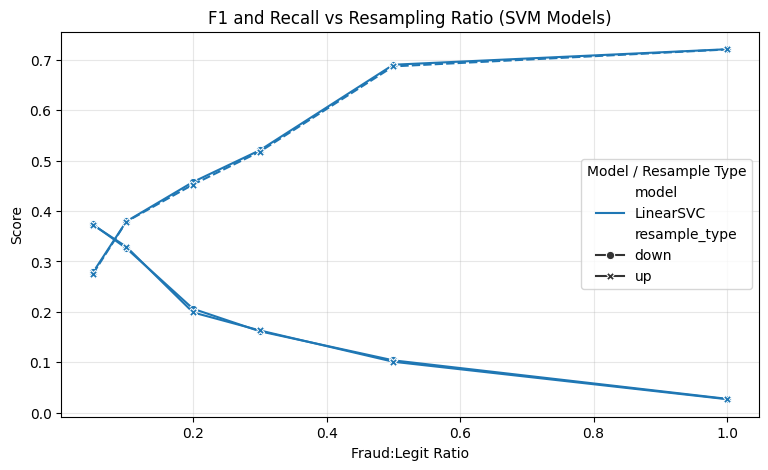

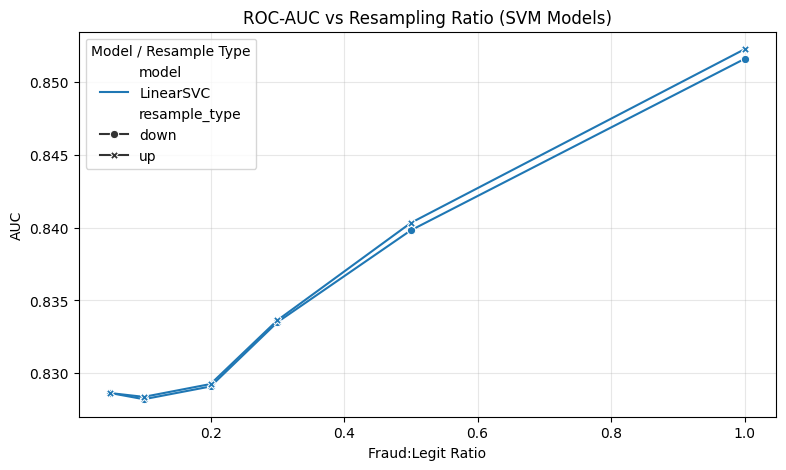

precision  recall     f1  roc_auc
model     ratio resample_type                                   
LinearSVC 0.05  down               0.567   0.278  0.373    0.829
                up                 0.575   0.276  0.373    0.829
          0.10  down               0.286   0.379  0.326    0.828
                up                 0.291   0.379  0.329    0.828
          0.20  down               0.133   0.458  0.206    0.829
                up                 0.127   0.453  0.199    0.829
          0.30  down               0.095   0.521  0.161    0.834
                up                 0.097   0.518  0.163    0.834
          0.50  down               0.056   0.690  0.104    0.840
                up                 0.054   0.687  0.101    0.840
          1.00  down               0.014   0.721  0.027    0.852
                up                 0.014   0.721  0.027    0.852

In [5]:
# ==============================================================
# Analyze and Visualize Results
# ==============================================================

results_df = pd.DataFrame(results).sort_values(by="f1", ascending=False).reset_index(drop=True)
display(results_df.head(10))

results_df.to_csv("results/svm_results.csv", index=False)
print("Saved results to results/svm_results.csv")

# ---- Plot F1 & Recall vs Ratio ----
plt.figure(figsize=(9,5))
sns.lineplot(data=results_df, x="ratio", y="f1", hue="model", style="resample_type", markers=True, dashes=False)
sns.lineplot(data=results_df, x="ratio", y="recall", hue="model", style="resample_type", markers=True, dashes=True, legend=False)
plt.title("F1 and Recall vs Resampling Ratio (SVM Models)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("Score")
plt.grid(True, alpha=0.3)
plt.legend(title="Model / Resample Type")
plt.show()

# ---- Plot ROC-AUC vs Ratio ----
plt.figure(figsize=(9,5))
sns.lineplot(data=results_df, x="ratio", y="roc_auc", hue="model", style="resample_type", markers=True, dashes=False)
plt.title("ROC-AUC vs Resampling Ratio (SVM Models)")
plt.xlabel("Fraud:Legit Ratio")
plt.ylabel("AUC")
plt.grid(True, alpha=0.3)
plt.legend(title="Model / Resample Type")
plt.show()

# ---- Summary Table ----
summary = results_df.groupby(["model", "ratio", "resample_type"])[["precision", "recall", "f1", "roc_auc"]].mean().round(3)
display(summary)
